# Impact of PayPal allowing crypto payments on bitcoin price (2020 October 21)

### Import libraries

In [31]:
!pip install yfinance # for price data
!pip install tfcausalimpact # for Google's causal impact

In [32]:
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller # for Dickey-Fuller test

### Define important dates

In [33]:
training_start = '2020-09-01'
training_end = '2020-10-19' # one day before treatment starts
treatment_start = '2020-10-20' # one day before PayPal accepts bitcoin
treatment_end = '2020-10-23'
end_stock = '2020-10-24'

### Load financial data

In [34]:
y = ['BTC-USD']
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = '1d')
y = y['Adj Close'].rename('y')
y

[*********************100%%**********************]  1 of 1 completed


Date
2020-09-01    11970.478516
2020-09-02    11414.034180
2020-09-03    10245.296875
2020-09-04    10511.813477
2020-09-05    10169.567383
2020-09-06    10280.351562
2020-09-07    10369.563477
2020-09-08    10131.516602
2020-09-09    10242.347656
2020-09-10    10363.138672
2020-09-11    10400.915039
2020-09-12    10442.170898
2020-09-13    10323.755859
2020-09-14    10680.837891
2020-09-15    10796.951172
2020-09-16    10974.905273
2020-09-17    10948.990234
2020-09-18    10944.585938
2020-09-19    11094.346680
2020-09-20    10938.271484
2020-09-21    10462.259766
2020-09-22    10538.459961
2020-09-23    10246.186523
2020-09-24    10760.066406
2020-09-25    10692.716797
2020-09-26    10750.723633
2020-09-27    10775.269531
2020-09-28    10709.652344
2020-09-29    10844.640625
2020-09-30    10784.491211
2020-10-01    10619.452148
2020-10-02    10575.974609
2020-10-03    10549.329102
2020-10-04    10669.583008
2020-10-05    10793.339844
2020-10-06    10604.406250
2020-10-07    10668.968

### Load stock data for control groups (uncorrelated to bitcoin)

In [35]:
tickers_control_group = ['ZAL.DE', 'SQ', 'CRSP', 'TRMB', 'JD', 'DE', 'KTOS', 'GOOG']

X = yf.download(tickers = tickers_control_group,
                start = training_start,
                end = end_stock,
                interval = '1d')

[*********************100%%**********************]  8 of 8 completed


### Data cleaning and preparation

In [36]:
# Get adjusted close price
X = X['Adj Close']

In [37]:
# Remove time zones
X.index = X.index.tz_localize(None)

In [38]:
# Combine treatment and control groups
df = pd.concat([y, X], axis = 1) # for CausalImpact first column must be y

In [39]:
# Remove NaNs
df.dropna(inplace = True)

### Data analysis

In [40]:
# Prepare dataframe with only training data
df_training = df[df.index <= training_end]
df_training.tail(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-10-19,11742.037109,107.720001,230.578705,76.730499,77.461121,20.639999,186.960007,51.970001,85.0


In [41]:
# Stationarity -> mean, variance and covariance do not depend on time
# Perform Dickey-Fuller test to check for stationarity
adfuller(x = df_training['y'])[1] # return p-value > 5%, so btc timeseries not stationary

0.0987470320882271

In [42]:
# Need to make time series stationary by the method of Differencing
differencing = df_training.pct_change().dropna()
differencing.head()

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-02,-0.046485,0.005459,-0.002664,0.040687,0.008728,0.010660,-0.022681,0.016851,0.000000
2020-09-03,-0.102395,-0.087725,-0.029018,-0.050015,-0.050114,-0.019588,-0.061518,-0.062788,-0.024935
2020-09-04,0.026014,-0.042829,0.002514,-0.030941,0.012146,-0.013320,-0.042326,-0.018468,-0.044486
2020-09-08,-0.036178,-0.006828,-0.005205,-0.036863,-0.047250,-0.001558,-0.049730,-0.016413,0.023697
2020-09-09,0.010939,0.046526,0.025114,0.016034,0.012726,0.016641,0.036662,0.019740,-0.009804


In [43]:
# Check again for stationarity
adfuller(x = differencing['y'])[1] # Now it's stationary!

3.8054323617260893e-07

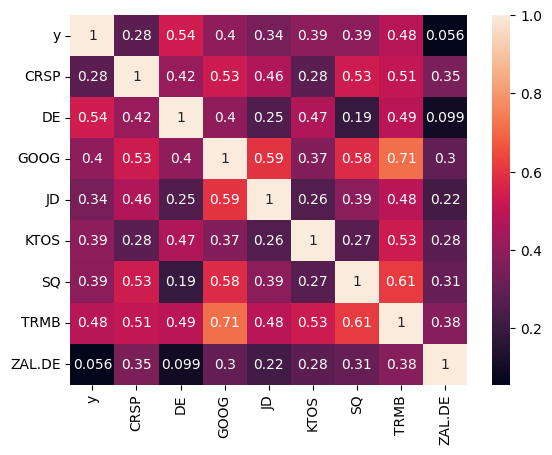

In [44]:
# Correlation between control and treatment group (finding stock most correlated to bitcoin)
sns.heatmap(differencing.corr(), annot = True) # ZAL.DE is going to be removed from control due to weak correlation
plt.show()

### Causal Impact

In [45]:
# drop ZAL.DE data
df = df.drop(columns = ['ZAL.DE'])
df.head(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB
Date,,,,,,,,
2020-09-01,11970.478516,93.419998,210.029663,83.0355,79.267685,19.700001,166.660004,53.41


In [46]:
# Define pre and post period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

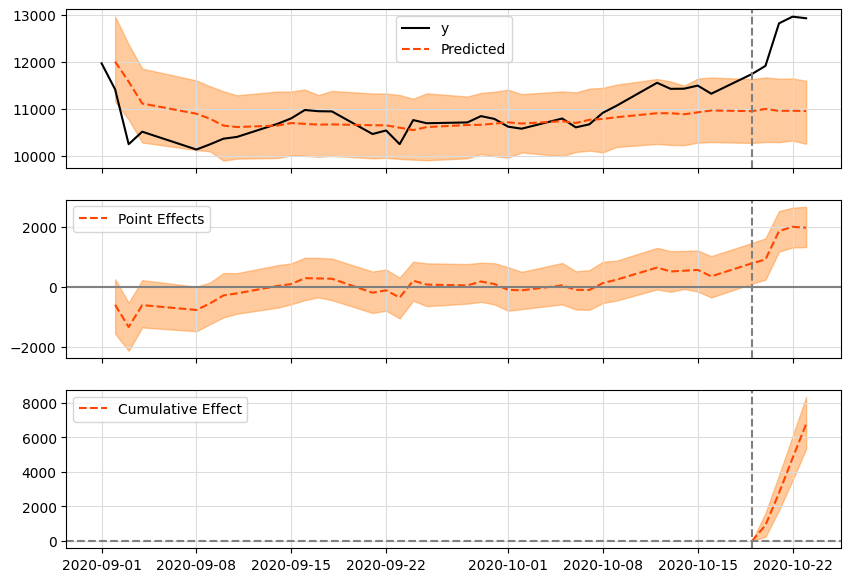

In [49]:
# GCI
impact = CausalImpact(data = df,
                      pre_period = pre_period,
                      post_period = post_period)
impact.plot()

In [51]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         10966.44 (199.89)  43865.76 (799.57)
95% CI                    [10595.38, 11378.95][42381.51, 45515.78]

Absolute effect (s.d.)    1692.92 (199.89)   6771.7 (799.57)
95% CI                    [1280.42, 2063.99] [5121.67, 8255.95]

Relative effect (s.d.)    15.44% (1.82%)     15.44% (1.82%)
95% CI                    [11.68%, 18.82%]   [11.68%, 18.82%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


### Summary report

In [52]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 12659.36. By contrast, in the absence of an
intervention, we would have expected an average response of 10966.44.
The 95% interval of this counterfactual prediction is [10595.38, 11378.95].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1692.92 with a 95% interval of
[1280.42, 2063.99]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 50637.45.
By contrast, had the intervention not taken place, we would have expected
a sum of 43865.76. The 95% interval of this prediction is [42381.51, 45515.78].


The above results are given in terms of absolute numbers. In relative
